<a href="https://colab.research.google.com/github/samuelsushanth/Telecom-Churn-Case-Study-Hackathon/blob/main/Telecom_Churn_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Churn Case Study Kaggle Competition
## Problem Statement
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.
## Objectives
Objectives
The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:

- It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

- It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

- Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely churn with more accuracy as compared to the ones who'll not churn. Make sure you mention which metric can be used in such scenarios.

- Recommend strategies to manage customer churn based on your observations.

In [1]:
!pip install scikit-optimize

from skopt import BayesSearchCV

!pip install optuna
import optuna




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.3 MB/s eta 0:00:00


In [2]:
# Importing Libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

from sklearn.pipeline import Pipeline

from imblearn.combine import SMOTETomek

from skopt import BayesSearchCV
from xgboost import XGBClassifier,XGBRFClassifier

import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler

import scipy.stats as stats

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,precision_recall_curve,PrecisionRecallDisplay,roc_auc_score,roc_curve
import optuna

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
#Removing display limit of dataframe (optional cell to run)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Setting style for seaonrn
sns.color_palette("seismic", 50)
sns.set_style("whitegrid", {'axes.grid' : False})

In [4]:
# Importing train dataset and displaying first 5 rows
tel_churn=pd.read_csv('train.csv')
tel_churn.head()

# Importing train dataset and displaying first 5 rows
tel_churn_test=pd.read_csv('test.csv')
tel_churn_test.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
0  69999        109             0.0             0.0             0.0            6/30/2014   
1  70000        109             0.0             0.0             0.0            6/30/2014   
2  70001        109             0.0             0.0             0.0            6/30/2014   
3  70002        109             0.0             0.0             0.0            6/30/2014   
4  70003        109             0.0             0.0             0.0            6/30/2014   

  last_date_of_month_7 last_date_of_month_8   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
0            7/31/2014            8/31/2014   91.882   65.330   64.445        31.78        20.23   
1            7/31/2014            8/31/2014  414.168  515.568  360.868        75.51        41.21   
2            7/31/2014            8/31/2014  329.844  434.884  746.239         7.54         7.86   
3            7/31/2014            8/31/2014   43.550  171.390   24.400         5.31         2.16   
4            7/31/2014            8/31/2014  306.854  406.289  413.329       450.93       609.03   

   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0        23.11         60.16         32.16         34.83           0.00           0.00   
1        19.84        474.34        621.84        394.94           0.00           0.00   
2         8.40         16.98         45.81         45.04          22.81         103.38   
3         0.00         40.04        205.01         24.01           0.00           0.00   
4       700.68         60.94         23.84         74.16           0.00           0.00   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0           0.00           0.00           0.00           0.00             24.88             20.23   
1           0.00           0.00           0.00           0.00             75.51             41.21   
2          26.08          24.53          53.68          54.44              0.00              0.00   
3           0.00           0.00           0.00           0.00              5.31              0.00   
4           0.00           0.00           0.00           0.00              0.45              0.78   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
0             21.06             18.13             10.89              8.36              0.00   
1             19.84            473.61            598.08            377.26              0.73   
2              0.00              0.00              0.00              0.00              0.00   
3              0.00              2.94             98.61             20.51              0.00   
4             14.56              2.39              2.66             10.94              0.00   

   loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0             13.58              0.00               0.0              0.00              0.03   
1              0.00              0.00               0.0              0.00              0.00   
2              0.00              0.00               0.0              0.00              0.00   
3              0.00              2.35               0.0              6.18              0.00   
4              0.00              0.00               0.0              0.00              0.00   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         43.01         44.71         29.43              6.90              0.00              2.05   
1        549.86        639.29        397.11              0.00              0.00              0.00   
2          0.00          0.00          0.00              0.00              0.00              0.00   
3          8.26         98.61         22.86              0.00              2.16              0.00   
4          2.84          3.44         25.51            45

In [5]:
# Shape of dataset
tel_churn.shape

(69999, 172)

In [6]:
# Information about dataset
tel_churn.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [7]:
#Basic information about the data
## Number of rows and columns
print('Number of Columns:',tel_churn.shape[1])
print('Number of Rows:',tel_churn.shape[0])
## Number of missing values
print('Number of missing values:',tel_churn.isnull().sum().sum())
## Number of unique values
print('Number of unique values:',tel_churn.nunique().sum())
## Number of duplicates
print('Number of duplicates:',tel_churn.duplicated().sum())

Number of Columns: 172
Number of Rows: 69999
Number of missing values: 1835086
Number of unique values: 1375105
Number of duplicates: 0


In [8]:
# Dataset Distribution
tel_churn.describe()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou        arpu_6  \
count  69999.000000    69999.0         69297.0         69297.0         69297.0  69999.000000   
mean   34999.000000      109.0             0.0             0.0             0.0    283.134365   
std    20207.115084        0.0             0.0             0.0             0.0    334.213918   
min        0.000000      109.0             0.0             0.0             0.0  -2258.709000   
25%    17499.500000      109.0             0.0             0.0             0.0     93.581000   
50%    34999.000000      109.0             0.0             0.0             0.0    197.484000   
75%    52498.500000      109.0             0.0             0.0             0.0    370.791000   
max    69998.000000      109.0             0.0             0.0             0.0  27731.088000   

             arpu_7        arpu_8   onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  \
count  69999.000000  69999.000000  67231.000000  67312.000000  66296.000000  67231.000000   
mean     278.185912    278.858826    133.153275    133.894438    132.978257    198.874771   
std      344.366927    351.924315    299.963093    311.277193    311.896596    316.818355   
min    -1289.715000   -945.808000      0.000000      0.000000      0.000000      0.000000   
25%       86.714000     84.095000      7.410000      6.675000      6.410000     34.860000   
50%      191.588000    192.234000     34.110000     32.280000     32.100000     96.480000   
75%      365.369500    369.909000    119.390000    115.837500    115.060000    232.990000   
max    35145.834000  33543.624000   7376.710000   8157.780000  10752.560000   8362.360000   

       offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
count  67312.000000  66296.000000   67231.000000   67312.000000   66296.000000   67231.000000   
mean     197.153383    196.543577       9.765435       7.014568       7.004892      14.186457   
std      322.482226    324.089234      57.374429      55.960985      53.408135      73.469261   
min        0.000000      0.000000       0.000000       0.000000       0.000000       0.000000   
25%       32.240000     31.575000       0.000000       0.000000       0.000000       0.000000   
50%       91.885000     91.800000       0.000000       0.000000       0.000000       0.000000   
75%      227.630000    229.345000       0.000000       0.000000       0.000000       0.000000   
max     7043.980000  14007.340000    2850.980000    4155.830000    4169.810000    3775.110000   

       roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   67312.000000   66296.000000      67231.000000      67312.000000      66296.000000   
mean        9.842191       9.771783         46.904854         46.166503         45.686109   
std        58.511894      64.618388        150.971758        154.739002        153.716880   
min         0.000000       0.000000          0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.650000          1.610000   
50%         0.000000       0.000000         11.910000         11.580000         11.740000   
75%         0.000000       0.000000         40.740000         39.760000         39.895000   
max      2812.040000    5337.040000       6431.330000       7400.660000      10752.560000   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
count      67231.000000      67312.000000      66296.000000      67231.000000      67312.000000   
mean          93.238231         90.799240         91.121447          3.743179          3.777031   
std          162.046699        153.852597        152.997805         13.319542         13.568110   
min            0.000000          0.000000          0.000000          0.000000          0.000000   
25%            9.920000         10.090000          9.830000          0.000000          0.000000   
50%     

In [9]:
# Checking Classes Distribution
tel_churn['churn_probability'].value_counts()/tel_churn.shape[0]*100

churn_probability
0    89.811283
1    10.188717
Name: count, dtype: float64

From describe() and info() we can see that data has large number of null values as well as outliers which needs to be handled. We will handle these issues in the next section.

## Cleaning the data

In [10]:
# Checking for missing value percentage
pd.DataFrame((tel_churn.isnull().sum()/len(tel_churn)*100).sort_values(ascending=False))

0
arpu_3g_6                 74.902499
count_rech_2g_6           74.902499
night_pck_user_6          74.902499
arpu_2g_6                 74.902499
date_of_last_rech_data_6  74.902499
...                             ...
last_day_rch_amt_8         0.000000
vol_2g_mb_6                0.000000
vol_2g_mb_7                0.000000
vol_2g_mb_8                0.000000
churn_probability          0.000000

[172 rows x 1 columns]

In [11]:
# Removing column with 30% or more null values as it will reduce the impact on analysis
tel_churn = tel_churn.loc[:,tel_churn.isnull().sum()/tel_churn.shape[0]*100<30]
# Shape of the dataframe after removing columns
tel_churn.shape

(69999, 142)

In [12]:
# Checking for missing value percentage
pd.DataFrame((tel_churn.isnull().sum()/len(tel_churn)*100).sort_values(ascending=False))

0
roam_og_mou_8      5.290076
og_others_8        5.290076
spl_og_mou_8       5.290076
loc_ic_t2t_mou_8   5.290076
loc_og_t2m_mou_8   5.290076
...                     ...
total_rech_amt_8   0.000000
max_rech_amt_6     0.000000
max_rech_amt_7     0.000000
max_rech_amt_8     0.000000
churn_probability  0.000000

[142 rows x 1 columns]

In [13]:
# Removing rows with missing values with more than 10 missing values
tel_churn.dropna(axis=0,inplace=True,thresh=tel_churn.shape[1]-10)
# Shape of the dataframe after removing rows
print(tel_churn.shape)

(63842, 142)


In [14]:
# List of columns with Date datatype
date_cols = [k for k in tel_churn.columns.to_list() if 'date' in k]
date_cols

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8']

In [15]:
# Converting Date columns to datetime datatype and extracting the days before last day
for i in date_cols:
    tel_churn[i] = pd.to_datetime(tel_churn[i])
    tel_churn[i] = tel_churn[i].dt.date
    tel_churn[i] = pd.to_datetime(tel_churn[i])
    tel_churn[i] = tel_churn[i].dt.daysinmonth - tel_churn[i].dt.day

# for test data set
for i in date_cols:
    tel_churn_test[i] = pd.to_datetime(tel_churn_test[i])
    tel_churn_test[i] = tel_churn_test[i].dt.date
    tel_churn_test[i] = pd.to_datetime(tel_churn_test[i])
    tel_churn_test[i] = tel_churn_test[i].dt.daysinmonth - tel_churn_test[i].dt.day

In [16]:
# Printing the date columns
tel_churn[date_cols].value_counts()

last_date_of_month_6  last_date_of_month_7  last_date_of_month_8  date_of_last_rech_6  date_of_last_rech_7  date_of_last_rech_8
0                     0                     0                     0.0                  0.0                  0.0                    1083
                                                                                                            1.0                     645
                                                                  1.0                  0.0                  0.0                     618
                                                                  0.0                  1.0                  0.0                     591
                                                                  1.0                  0.0                  1.0                     435
                                                                                                                                   ... 
                                                                  10.0                 15.0                 23.0                      1
                                                                                                            18.0                      1
                                                                                                            11.0                      1
                                                                                                            9.0                       1
                                                                  29.0                 27.0                 3.0                       1
Name: count, Length: 9163, dtype: int64

In [17]:
# Removing the columns with only one unique value among date columns
tel_churn.drop(columns=['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'],inplace=True)
date_cols.remove('last_date_of_month_6')
date_cols.remove('last_date_of_month_7')
date_cols.remove('last_date_of_month_8')

# for test data set
tel_churn_test.drop(columns=['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'],inplace=True)

In [18]:
# Removing duplicate ID columns
tel_churn.drop(['circle_id'],axis=1,inplace=True)
# for test data set
tel_churn_test.drop(['circle_id'],axis=1,inplace=True)

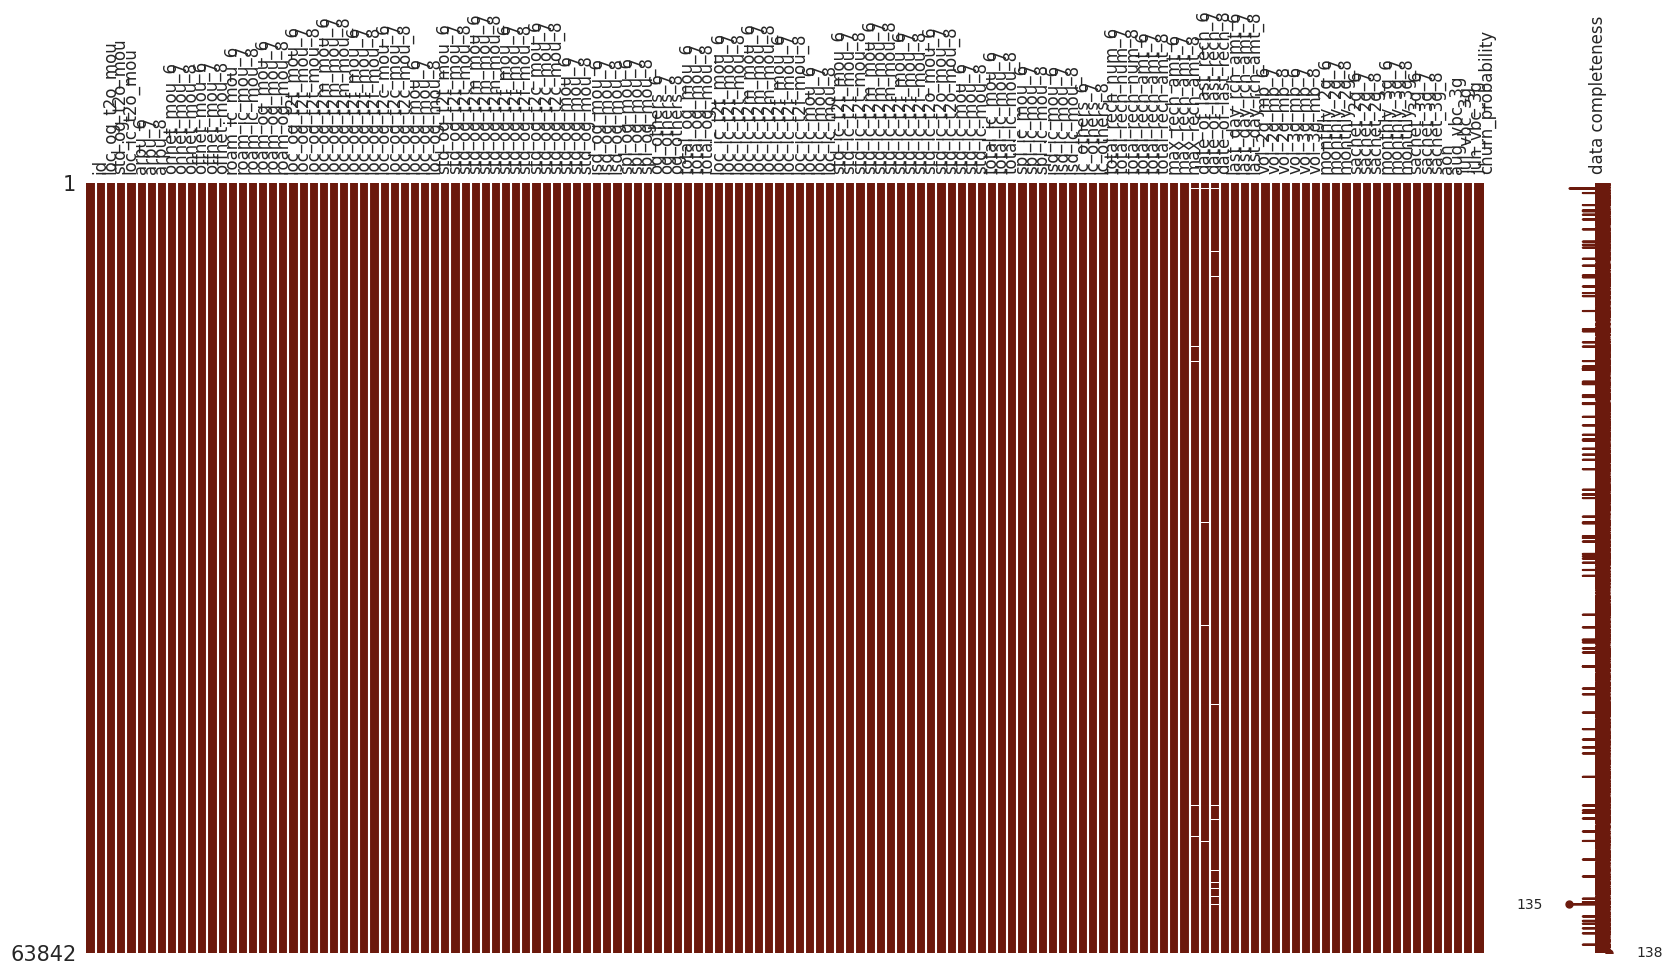

In [19]:
import missingno as msno
msno.matrix(tel_churn,figsize=(20,10),fontsize=12,color=(0.42, 0.1, 0.05),sparkline=True,labels=True,label_rotation=90)
plt.show()

As it is evident from the chart there is some missing values in the data. We will try to find the pattern and fill the missing values accordingly. We are using MICE technique to fill the missing values.

In [20]:
# Using MICE to impute missing values
imp = IterativeImputer(estimator=BayesianRidge(),max_iter=10, random_state=0)
# Fitting the imputer for each index in date columns
for i in date_cols:
    tel_churn[i] = imp.fit_transform(tel_churn[i].values.reshape(-1,1))

All the missing values are filled and thus can proceed with the next step of data analysis. As all columns are numeric we can proceed with scatter charts to find the correlation between the columns. One last step to remove unwanted columns from the data which have only one value.

In [21]:
# Remove Columns with only one unique value
tel_churn = tel_churn.loc[:,tel_churn.nunique()!=1]
tel_churn.shape

(63842, 129)

## Deriving new features

In [22]:
# Average recharge amount for June and July
tel_churn['avg_rech_amt_6_7']=((tel_churn['total_rech_amt_6']+tel_churn['total_rech_amt_7'])/2)
# for test data set
tel_churn_test['avg_rech_amt_6_7']=((tel_churn_test['total_rech_amt_6']+tel_churn_test['total_rech_amt_7'])/2)

In [23]:
# Days user with company
tel_churn['days_stayed'] = tel_churn['date_of_last_rech_8'] - tel_churn['date_of_last_rech_6']
# for test data set
tel_churn_test['days_stayed'] = tel_churn_test['date_of_last_rech_8'] - tel_churn_test['date_of_last_rech_6']

In [24]:
# Average 3g usage for June and July
tel_churn['avg_3g_6_7']=((tel_churn['vol_3g_mb_6']+tel_churn['vol_3g_mb_7'])/2)
# for test data set
tel_churn_test['avg_3g_6_7']=((tel_churn_test['vol_3g_mb_6']+tel_churn_test['vol_3g_mb_7'])/2)

In [25]:
# Average 2g usage for June and July
tel_churn['avg_2g_6_7']=((tel_churn['vol_2g_mb_6']+tel_churn['vol_2g_mb_7'])/2)
# for test data set
tel_churn_test['avg_2g_6_7']=((tel_churn_test['vol_2g_mb_6']+tel_churn_test['vol_2g_mb_7'])/2)

In [26]:
# Avergae of 6th and 7th month total usage
tel_churn['avg_total_6_7']=((tel_churn['total_og_mou_6']+tel_churn['total_og_mou_7'])/2)
# for test data set
tel_churn_test['avg_total_6_7']=((tel_churn_test['total_og_mou_6']+tel_churn_test['total_og_mou_7'])/2)

In [27]:
# Avg. mou at action phase
# We are taking average because there are two months(7 and 8) in action phase
tel_churn['avg_mou_action'] = (tel_churn['total_og_mou_7'] + tel_churn['total_og_mou_8'] + tel_churn['total_ic_mou_7'] + tel_churn['total_ic_mou_8'])/2
# for test data set
tel_churn_test['avg_mou_action'] = (tel_churn_test['total_og_mou_7'] + tel_churn_test['total_og_mou_8'] + tel_churn_test['total_ic_mou_7'] + tel_churn_test['total_ic_mou_8'])/2

In [28]:
# ARUP in action phase
tel_churn['avg_arpu_action'] = (tel_churn['arpu_7'] + tel_churn['arpu_8'])/2
# Difference of good and action phase ARPU
tel_churn['diff_arpu'] = tel_churn['avg_arpu_action'] - tel_churn['arpu_6']
# Checking whether the arpu has decreased on the action month
tel_churn['decrease_arpu_action'] = np.where(tel_churn['diff_arpu'] < 0, 1, 0)

# ARUP in action phase
tel_churn_test['avg_arpu_action'] = (tel_churn_test['arpu_7'] + tel_churn_test['arpu_8'])/2
# Difference of good and action phase ARPU
tel_churn_test['diff_arpu'] = tel_churn_test['avg_arpu_action'] - tel_churn_test['arpu_6']
# Checking whether the arpu has decreased on the action month
tel_churn_test['decrease_arpu_action'] = np.where(tel_churn_test['diff_arpu'] < 0, 1, 0)

## Filtering High-Value Customers

In [29]:
# Filtering the customers based on average recharge amount
perc_6_7=tel_churn['avg_rech_amt_6_7'].quantile(0.70)
tel_churn=tel_churn[tel_churn['avg_rech_amt_6_7']>=perc_6_7]
tel_churn.shape

(19180, 138)

In [30]:
# Column list with id and target variable
col_list_bar = tel_churn.columns.to_list()
col_list_bar.remove('churn_probability')
col_list_bar.remove('id')

## Outlier Treatment

In [31]:
# Removing outlier using z-score method
z = np.abs(stats.zscore(tel_churn[col_list_bar]))
tel_churn = tel_churn[(z < 5).all(axis=1)]
tel_churn.shape

(14259, 138)

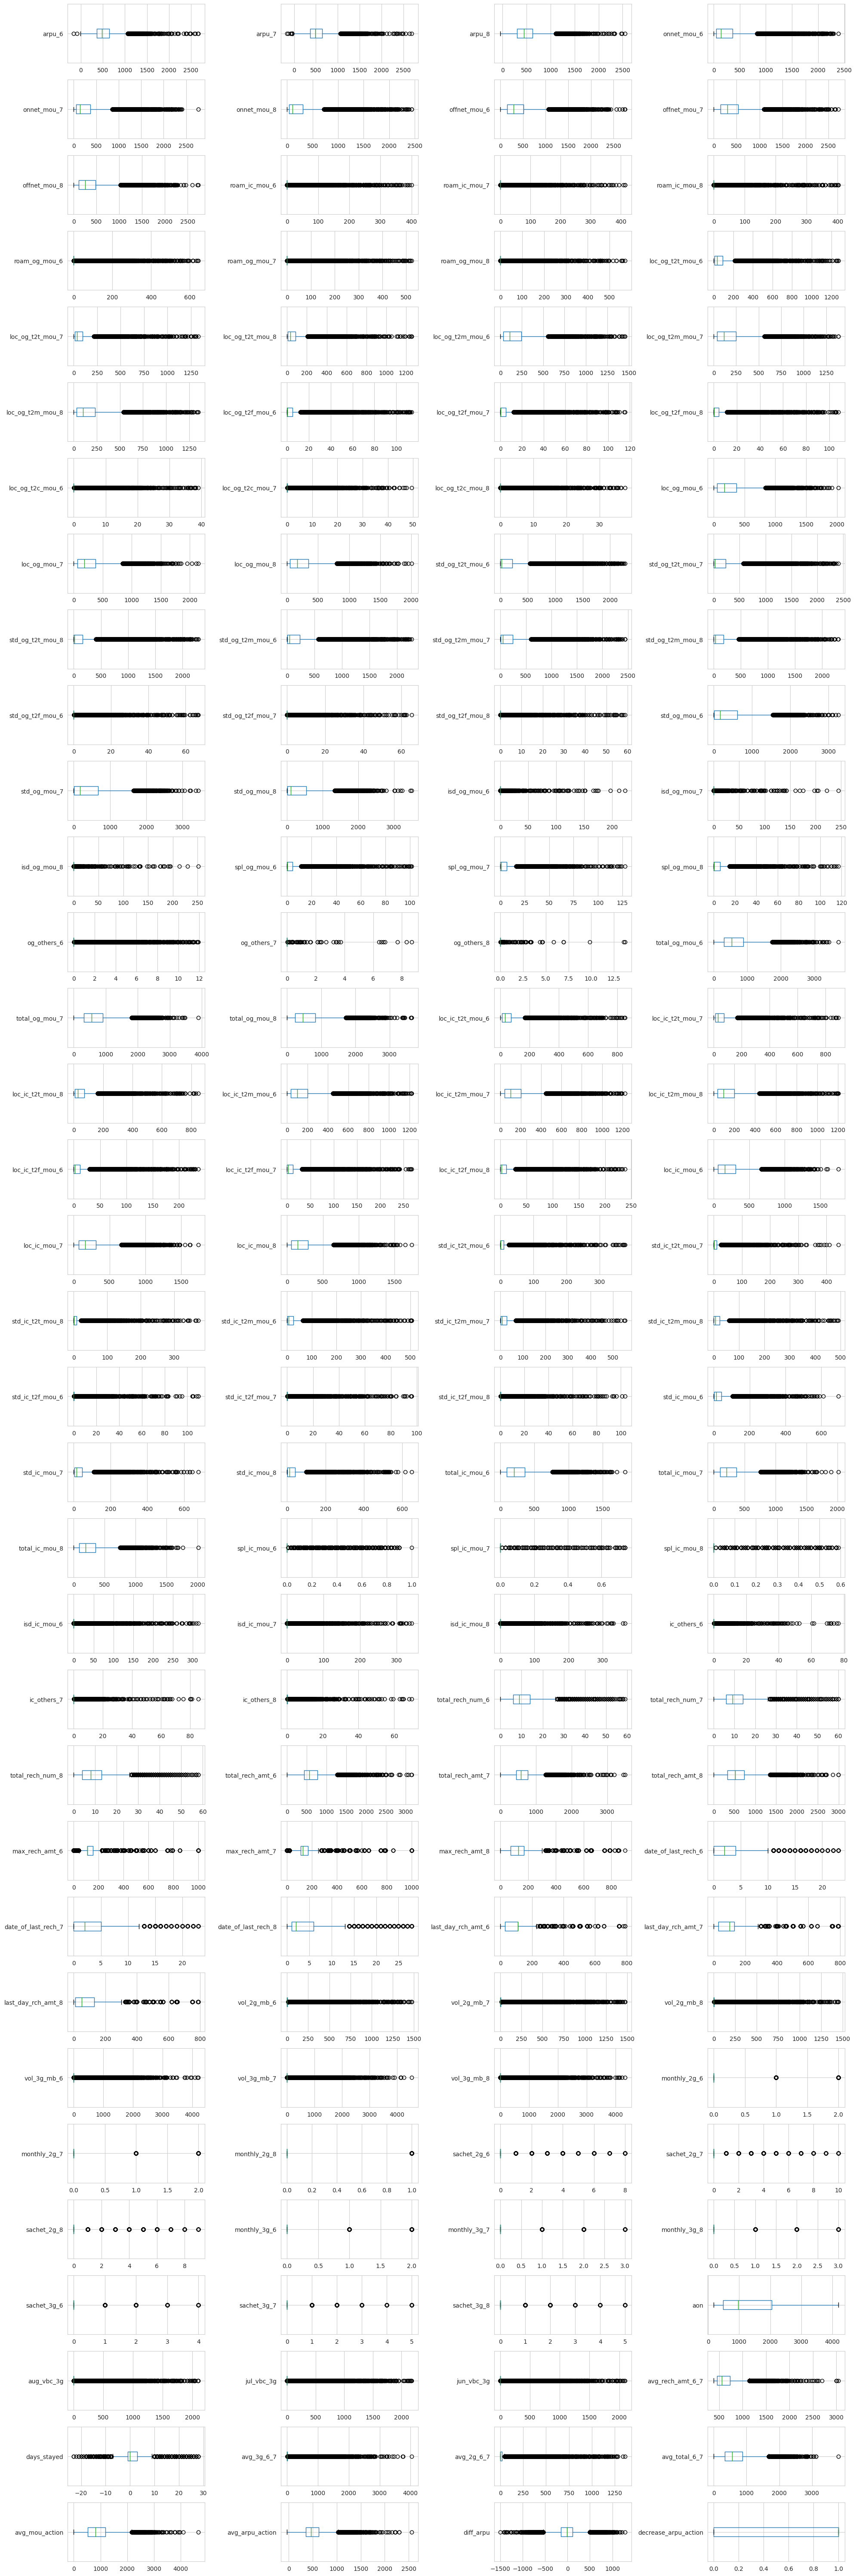

In [32]:
# Checking for outliers using boxplot in a 34 by 4 grid
fig, ax = plt.subplots(34, 4, figsize=(20, 60))
for variable, subplot in zip(col_list_bar, ax.flatten()):
    tel_churn.boxplot(column=variable, ax=subplot, vert=False)
plt.tight_layout()
plt.show()

As the outluers are present in large number and IQR method will result in loss of data we used z score method. As we are using a model to predict the churn we can use a model which is robust to outliers.

In [33]:
# Creating copy of dataframe for Predictive model
tel_churn_pred = tel_churn.copy()

## Uni-variate Analysis

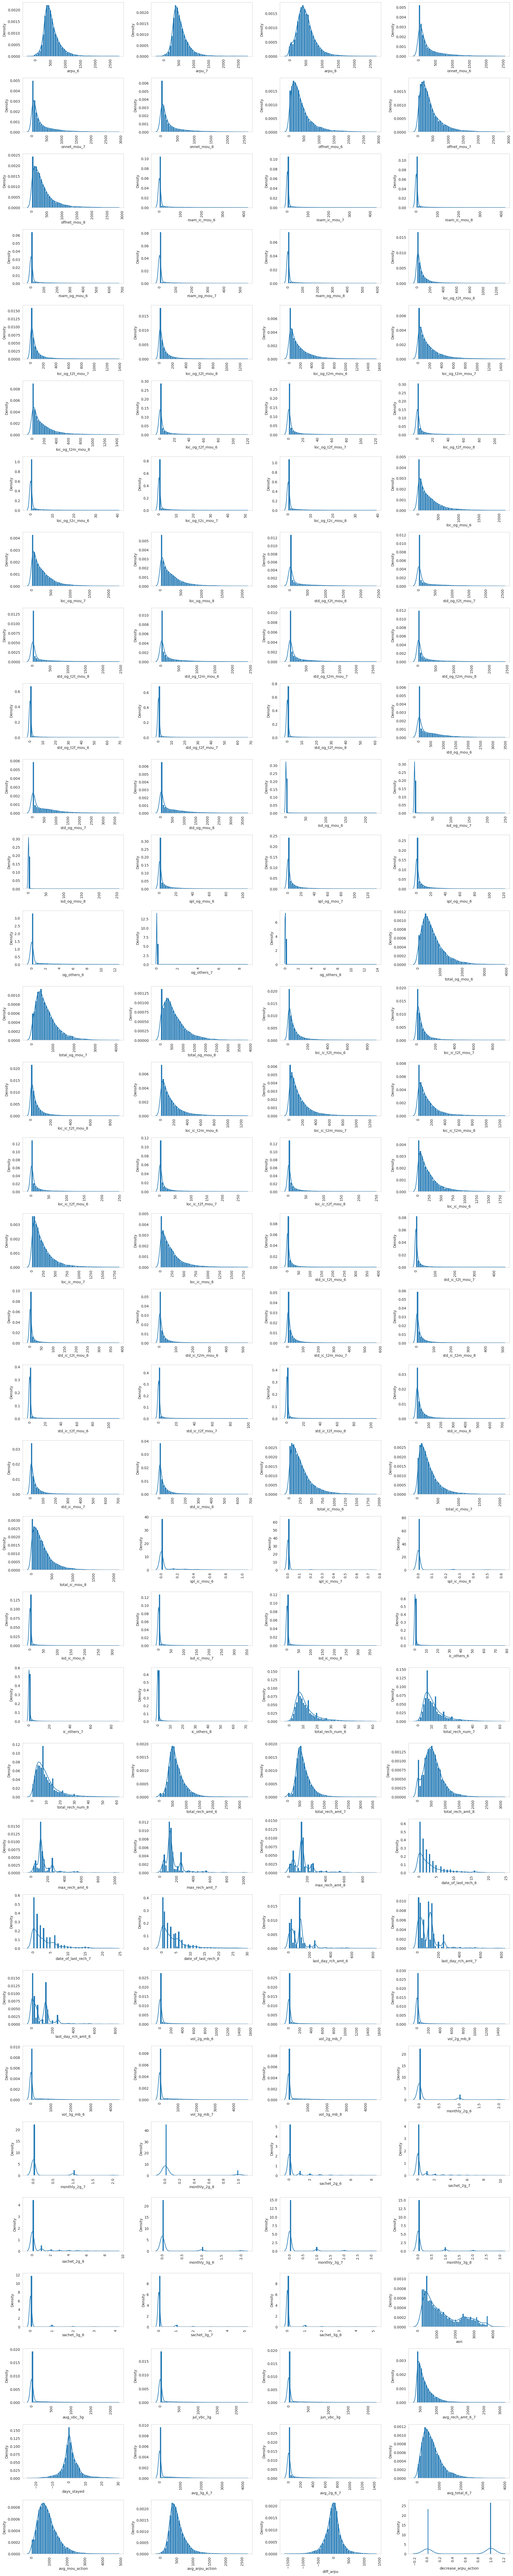

In [34]:
# Checking for distribution using distplot in a 34 by 4 grid
fig, ax = plt.subplots(34, 4, figsize=(20, 100))
for variable, subplot in zip(col_list_bar, ax.flatten()):
    sns.distplot(tel_churn[variable], ax=subplot,kde=True, bins=50, hist_kws={'alpha': 1})
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
plt.tight_layout()
plt.show()

## Bi-variate Analysis

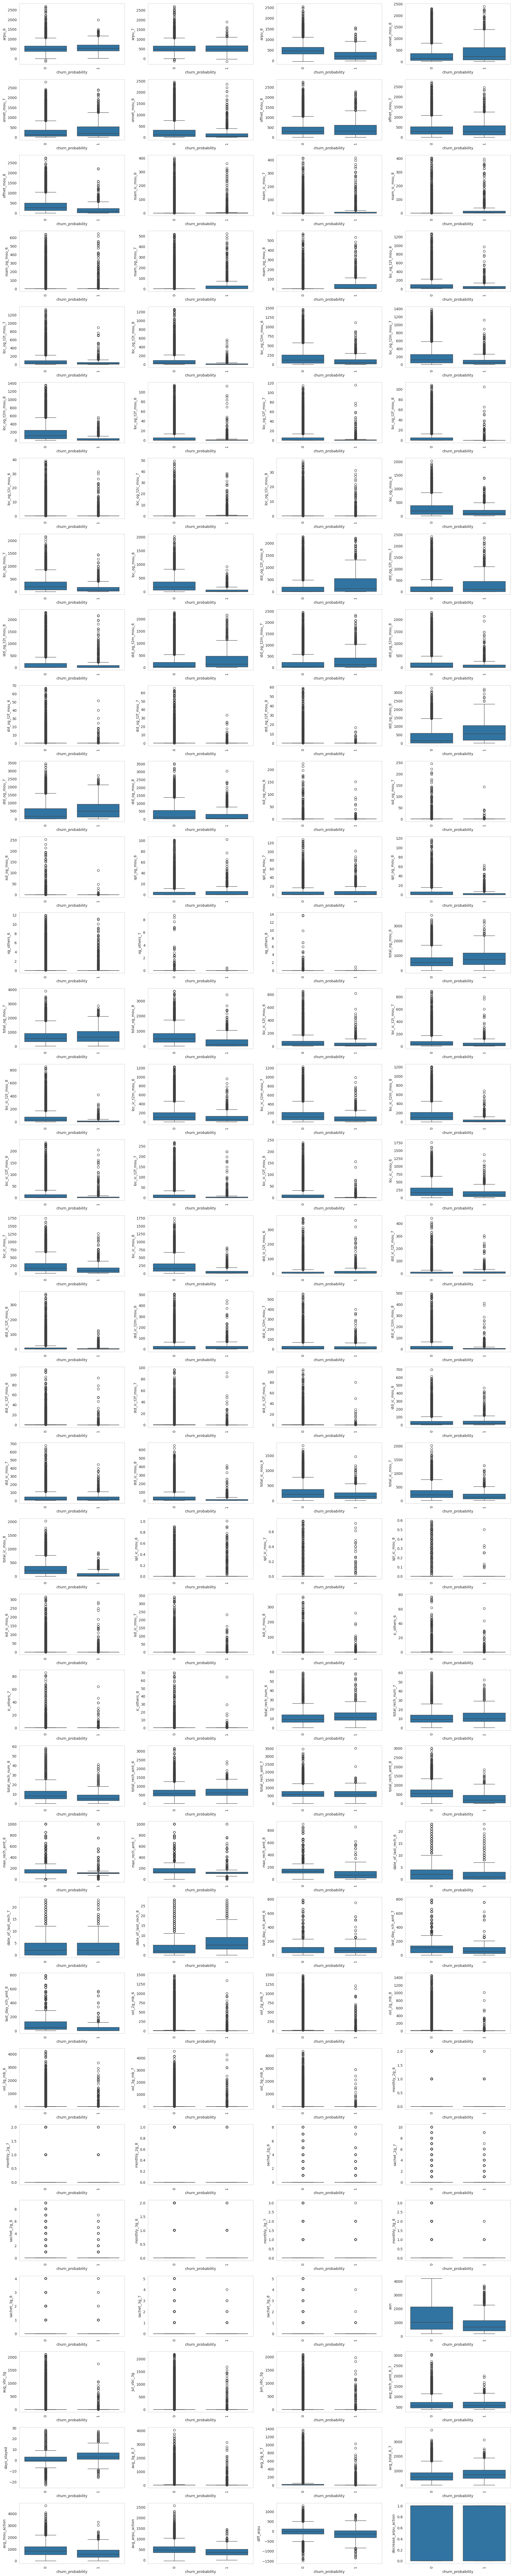

In [35]:
# Bivariate analysis of churn probability with other variables
fig, ax = plt.subplots(34, 4, figsize=(20, 100))
for variable, subplot in zip(col_list_bar, ax.flatten()):
    sns.boxplot(x='churn_probability', y=variable, data=tel_churn, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
plt.tight_layout()
plt.show()

## Multi-variate Analysis

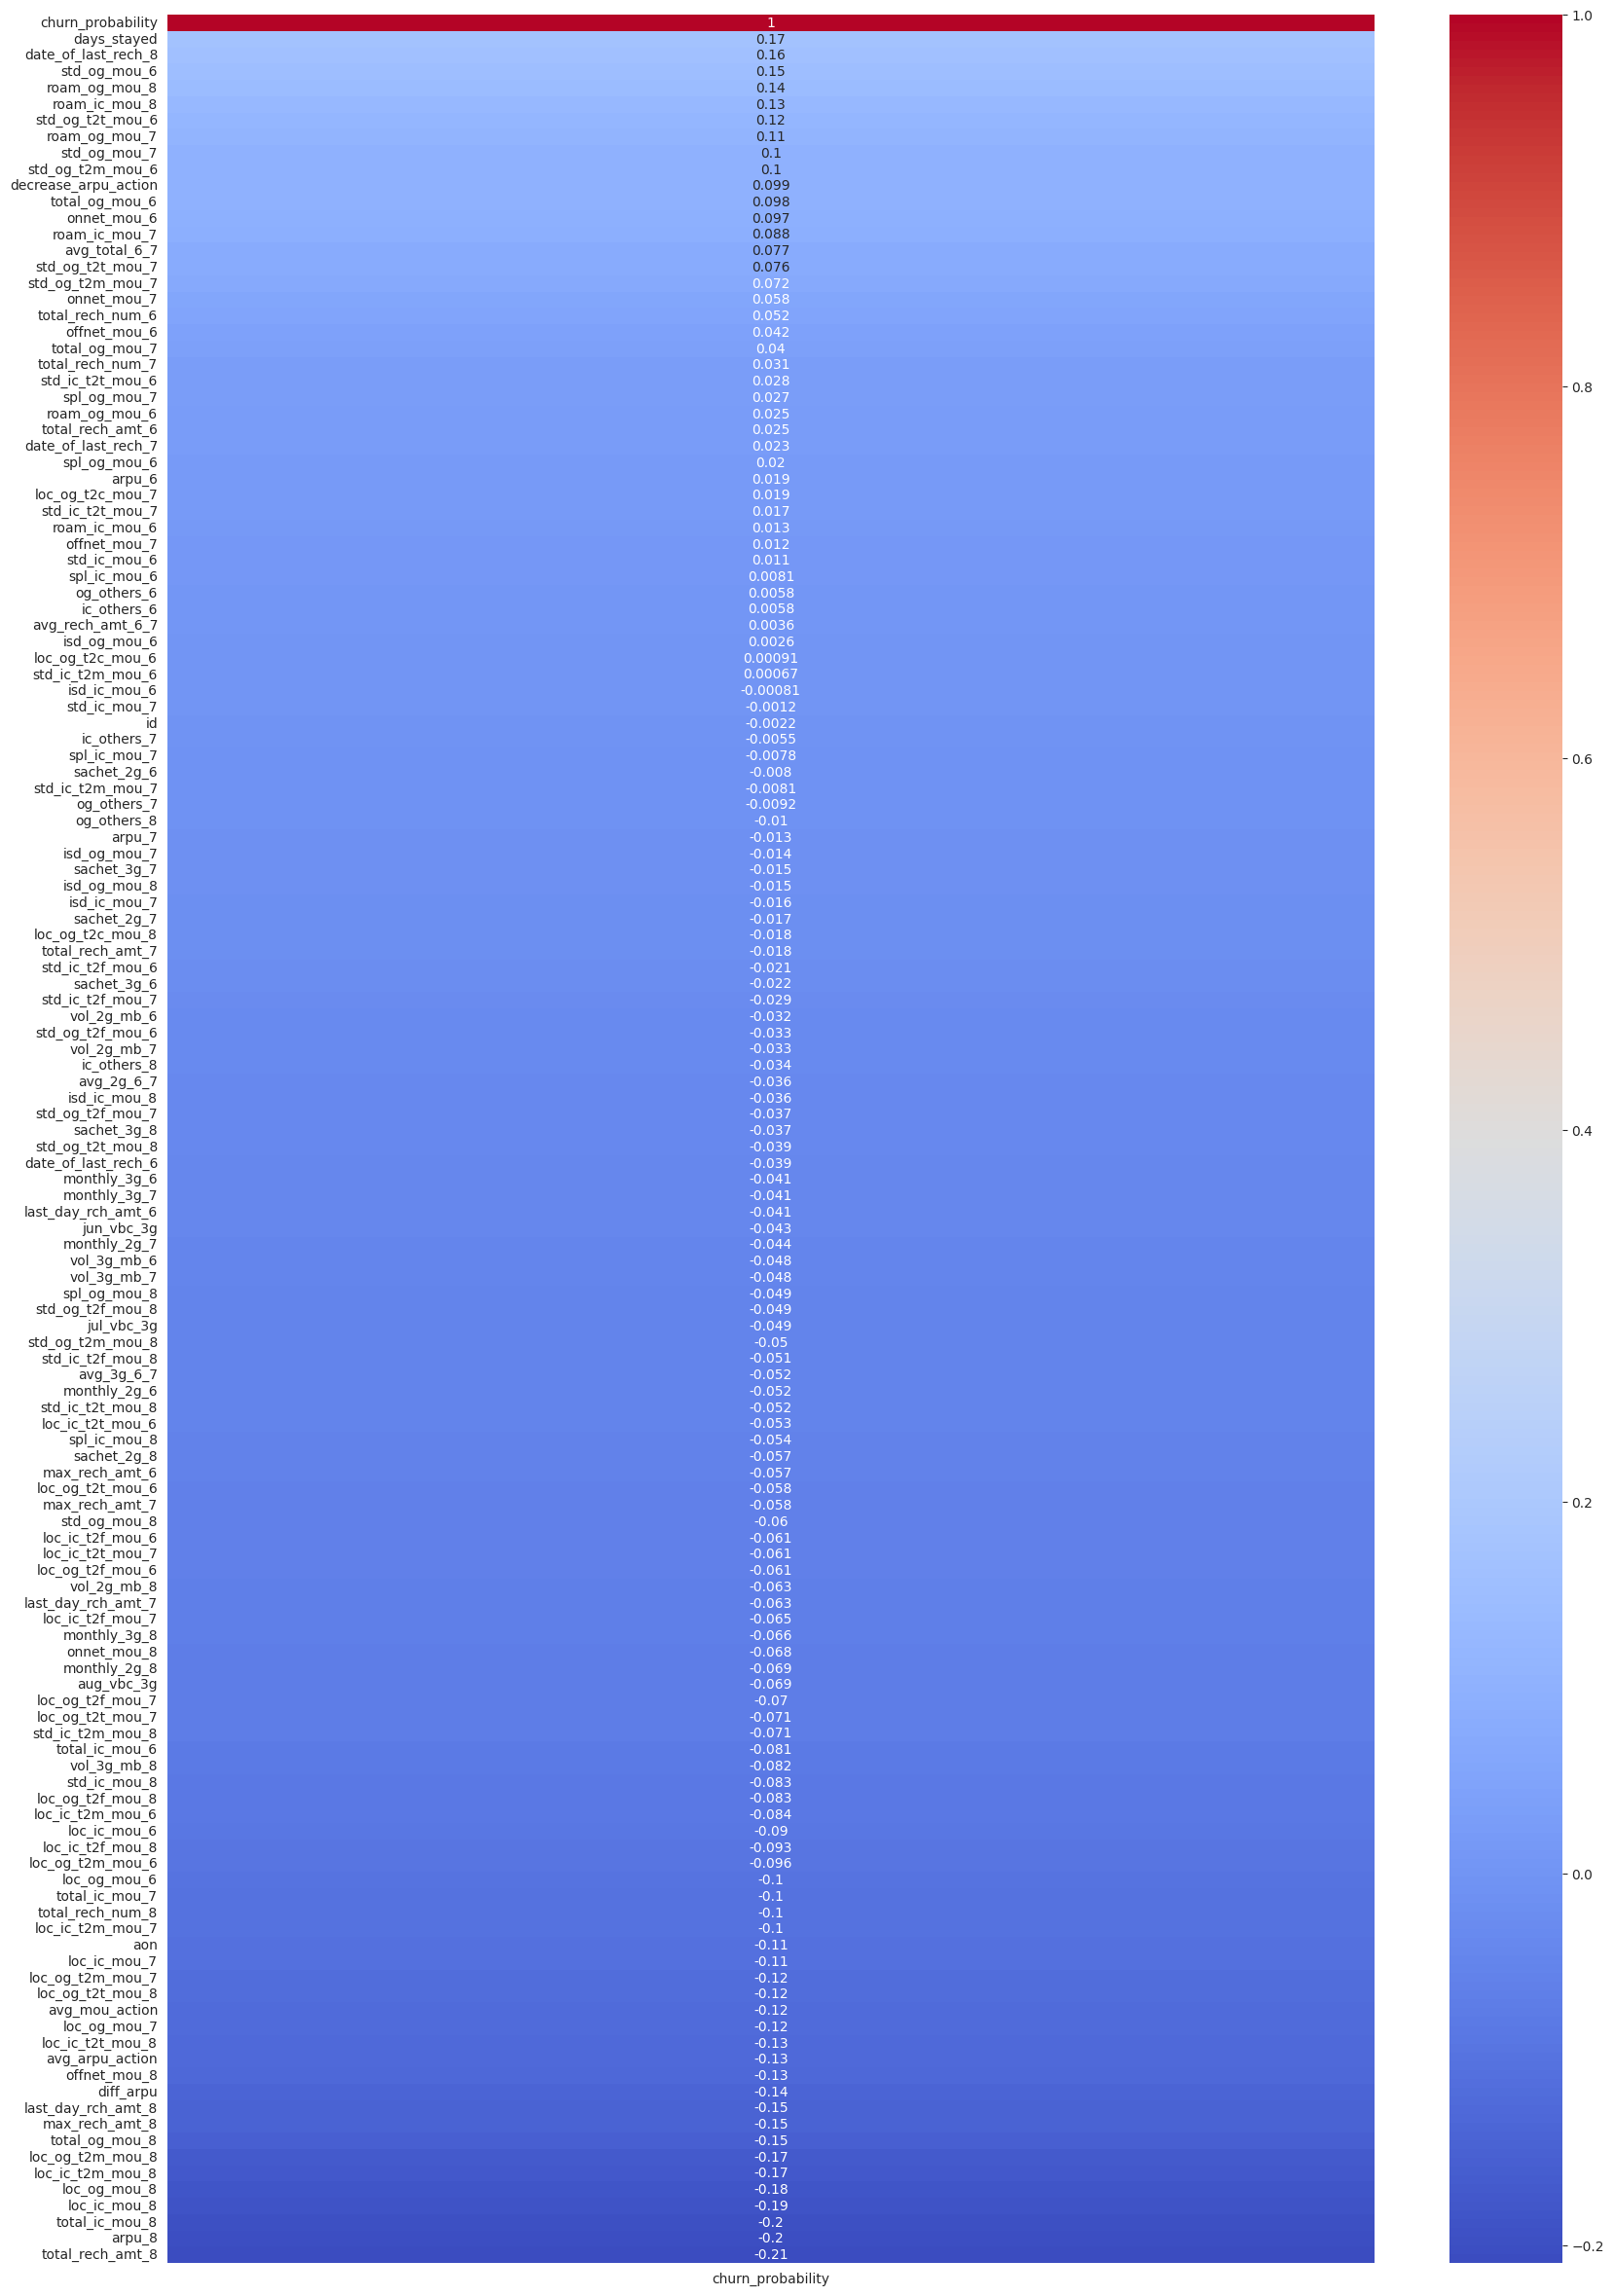

In [36]:
# Heatmap with target variable
plt.figure(figsize=(20,30))
sns.heatmap(tel_churn_pred.corr()[['churn_probability']].sort_values(by='churn_probability',ascending=False),cmap='coolwarm',annot=True)
plt.show()

As we are using a model to predict the churn we can use a model which is robust to multi-collinearity and outliers.

## Model Building for Predicting Churn OBJECTIVE 1

In [37]:
# train test split
X = tel_churn_pred.drop(['id','churn_probability'],axis=1)
y = tel_churn_pred['churn_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=71, stratify=y)

In [38]:
# Using Combined sampling to handle imbalanced dataset
smt = SMOTETomek(random_state=71, sampling_strategy=0.25, n_jobs=-1)
X_train, y_train = smt.fit_resample(X_train, y_train)

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13290, 136), (2852, 136), (13290,), (2852,))

In [40]:
# Standardization method
scaler = MinMaxScaler()
X_train[col_list_bar] = scaler.fit_transform(X_train[col_list_bar])
X_test[col_list_bar] = scaler.transform(X_test[col_list_bar])
tel_churn_test[col_list_bar] = scaler.transform(tel_churn_test[col_list_bar])

**bold text**## Model Selection using RandomizedSearchCV

In [41]:
def objective(trial):
    """Define the objective function"""

    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 600),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "subsample": trial.suggest_loguniform("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.01, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 1.0),
        "eval_metric": "mlogloss",
        "use_label_encoder": [False, True],
    }

    # Fit the model
    optuna_model = XGBRFClassifier(
        **params, random_state=71, n_jobs=-1,tree_method='gpu_hist', gpu_id=0
    )
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    return accuracy_score(y_test, y_pred)

In [42]:
def objective(trial):
    """Define the objective function"""

    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 600),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "subsample": trial.suggest_loguniform("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.01, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 1.0),
        "eval_metric": "mlogloss",
        "use_label_encoder": trial.suggest_categorical("use_label_encoder", [False, True]),
    }

    # Fit the model
    optuna_model = XGBRFClassifier(
        **params,
        random_state=71,
        n_jobs=-1,
        tree_method='hist',  # Use 'hist' instead of 'gpu_hist'
        gpu_id=None  # Explicitly disable GPU usage
    )
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    return accuracy_score(y_test, y_pred)

In [43]:
!pip install --upgrade xgboost




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 2.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [44]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2024-08-22 19:44:48,282] A new study created in memory with name: no-name-272bb95e-c26e-4c9f-a1f7-922013f63d87
[I 2024-08-22 19:45:12,816] Trial 0 finished with value: 0.9354838709677419 and parameters: {'max_depth': 4, 'learning_rate': 0.2036723365350545, 'n_estimators': 471, 'min_child_weight': 2, 'gamma': 5.9573617123287394e-08, 'subsample': 0.012146880232199496, 'colsample_bytree': 0.020891985795759755, 'reg_alpha': 0.003348844614488114, 'reg_lambda': 2.4108107983537654e-07, 'use_label_encoder': True}. Best is trial 0 with value: 0.9354838709677419.
[I 2024-08-22 19:45:20,577] Trial 1 finished with value: 0.9354838709677419 and parameters: {'max_depth': 3, 'learning_rate': 0.02275435536552299, 'n_estimators': 227, 'min_child_weight': 9, 'gamma': 0.02136086513098077, 'subsample': 0.08337200642732448, 'colsample_bytree': 0.010493323652008904, 'reg_alpha': 0.0006878448147296984, 'reg_lambda': 0.001089643097142736, 'use_label_encoder': False}. Best is trial 0 with value: 0.935483870

In [45]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 500
Best trial:
  Value: 0.9393408134642356
  Params: 
    max_depth: 6
    learning_rate: 0.8103030862173255
    n_estimators: 405
    min_child_weight: 1
    gamma: 0.01356372815485272
    subsample: 0.9547034602214081
    colsample_bytree: 0.1319148366272341
    reg_alpha: 0.04031282201112568
    reg_lambda: 0.0005663243412992872
    use_label_encoder: True


In [46]:
params = trial.params
model = XGBRFClassifier(**params, random_state=71)
model.fit(X_train, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=0.1319148366272341,
                device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=0.01356372815485272, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.8103030862173255, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=6, max_leaves=None,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=405, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=71, ...)

## Model Evaluation

In [47]:
y_pred_train = model.predict(X_test)
print('Accuracy:',accuracy_score(y_test,y_pred_train))
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_train).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Specificity:',specificity)

Accuracy: 0.9393408134642356
Specificity: 0.9778860569715142


## Output for Solution

In [48]:
# output the predicted the class for test data
output=pd.DataFrame({"id":tel_churn_test.id,"churn_probability":model.predict(tel_churn_test[X_train.columns])})
output.to_csv('submission.csv',index=False)

In [49]:
# checking submission accuracy
solution=pd.read_csv("solution.csv")
solution.head()
accuracy_score(solution.churn_probability,output.churn_probability)

0.9069666666666667

## Model Building for feature importance OBJECTIVE 2

In [50]:
# Making copy for feature importance
tel_churn_features = tel_churn.copy()
X_feature=tel_churn_features[col_list_bar]
y_feature=tel_churn_features['churn_probability']

In [51]:
# Using Combined sampling to handle imbalanced dataset
smt = SMOTETomek(random_state=40, sampling_strategy=0.2, n_jobs=-1)
X_feature, y_feature = smt.fit_resample(X_feature, y_feature)

In [52]:
# Standardization method
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_feature[col_list_bar] = scaler.fit_transform(X_feature[col_list_bar])

In [53]:
# extract feature importance
model = XGBClassifier(random_state=80)
model.fit(X_feature, y_feature)
importance = model.feature_importances_
# summarize feature importance
feature_imp=pd.DataFrame({"feature":X_feature.columns,"importance":importance/np.sum(importance)*100})
feature_imp.sort_values(by='importance',ascending=False,inplace=True)
feature_imp=feature_imp[feature_imp.importance>0]
feature_imp

feature  importance
14          roam_og_mou_8    9.188859
11          roam_ic_mou_8    6.260097
80         total_ic_mou_8    5.335240
113          monthly_2g_8    3.646520
95       total_rech_amt_8    2.937884
..                    ...         ...
126            jun_vbc_3g    0.196058
135  decrease_arpu_action    0.160930
38       std_og_t2f_mou_8    0.136688
120           sachet_3g_6    0.129983
119          monthly_3g_8    0.115173

[133 rows x 2 columns]

In [54]:
# Extracting features above 30% quantile for feature importance
feature_imp_50=feature_imp[feature_imp.importance>feature_imp.importance.quantile(0.3)]
feature_imp_50

feature  importance
14         roam_og_mou_8    9.188859
11         roam_ic_mou_8    6.260097
80        total_ic_mou_8    5.335240
113         monthly_2g_8    3.646520
95      total_rech_amt_8    2.937884
104   last_day_rch_amt_8    2.579834
118         monthly_3g_7    2.343520
29          loc_og_mou_8    2.212955
98        max_rech_amt_8    2.178739
101  date_of_last_rech_8    1.797686
65          loc_ic_mou_8    1.649059
2                 arpu_8    1.620960
40          std_og_mou_7    1.492288
110          vol_3g_mb_8    1.456487
99   date_of_last_rech_6    1.382229
128          days_stayed    1.330958
83          spl_ic_mou_8    1.070331
13         roam_og_mou_7    0.964095
59      loc_ic_t2m_mou_8    0.900460
97        max_rech_amt_7    0.892593
102   last_day_rch_amt_6    0.854671
111         monthly_2g_6    0.839664
103   last_day_rch_amt_7    0.828083
81          spl_ic_mou_6    0.810369
109          vol_3g_mb_7    0.798418
48           og_others_6    0.789162
112         monthly_2g_7    0.776928
107          vol_2g_mb_8    0.739879
53        total_og_mou_8    0.726557
100  date_of_last_rech_7    0.721778
90      total_rech_num_6    0.693049
26      loc_og_t2c_mou_8    0.690809
89           ic_others_8    0.685248
79        total_ic_mou_7    0.675645
43          isd_og_mou_7    0.664944
71      std_ic_t2m_mou_8    0.614095
46          spl_og_mou_7    0.613076
96        max_rech_amt_6    0.611870
32      std_og_t2t_mou_8    0.607237
44          isd_og_mou_8    0.605824
116          sachet_2g_8    0.587867
86          isd_ic_mou_8    0.582174
25      loc_og_t2c_mou_7    0.564909
55      loc_ic_t2t_mou_7    0.558435
41          std_og_mou_8    0.554643
31      std_og_t2t_mou_7    0.535880
130           avg_2g_6_7    0.524595
45          spl_og_mou_6    0.518357
124           aug_vbc_3g    0.511357
72      std_ic_t2f_mou_6    0.506705
82          spl_ic_mou_7    0.502896
114          sachet_2g_6    0.502742
22      loc_og_t2f_mou_7    0.499999
10         roam_ic_mou_7    0.498907
94      total_rech_amt_7    0.496834
123                  aon    0.493773
67      std_ic_t2t_mou_7    0.493016
51        total_og_mou_6    0.492895
21      loc_og_t2f_mou_6    0.482228
74      std_ic_t2f_mou_8    0.475656
64          loc_ic_mou_7    0.461481
56      loc_ic_t2t_mou_8    0.455691
84          isd_ic_mou_6    0.454724
106          vol_2g_mb_7    0.453599
52        total_og_mou_7    0.453051
47          spl_og_mou_8    0.450528
77          std_ic_mou_8    0.445810
34      std_og_t2m_mou_7    0.439933
76          std_ic_mou_7    0.434351
91      total_rech_num_7    0.433523
61      loc_ic_t2f_mou_7    0.430891
60      loc_ic_t2f_mou_6    0.428506
36      std_og_t2f_mou_6    0.420171
93      total_rech_amt_6    0.419299
42          isd_og_mou_6    0.410619
24      loc_og_t2c_mou_6    0.407344
1                 arpu_7    0.407295
35      std_og_t2m_mou_8    0.401254
28          loc_og_mou_7    0.397230
3            onnet_mou_6    0.395369
4            onnet_mou_7    0.395356
87           ic_others_6    0.393860
108          vol_3g_mb_6    0.391070
37      std_og_t2f_mou_7    0.385336
66      std_ic_t2t_mou_6    0.384904
63          loc_ic_mou_6    0.381601
8           offnet_mou_8    0.376498
58      loc_ic_t2m_mou_7    0.373667
62      loc_ic_t2f_mou_8    0.371600
23      loc_og_t2f_mou_8    0.365313
16      loc_og_t2t_mou_7    0.363856
85          isd_ic_mou_7    0.346833
19      loc_og_t2m_mou_7    0.342453

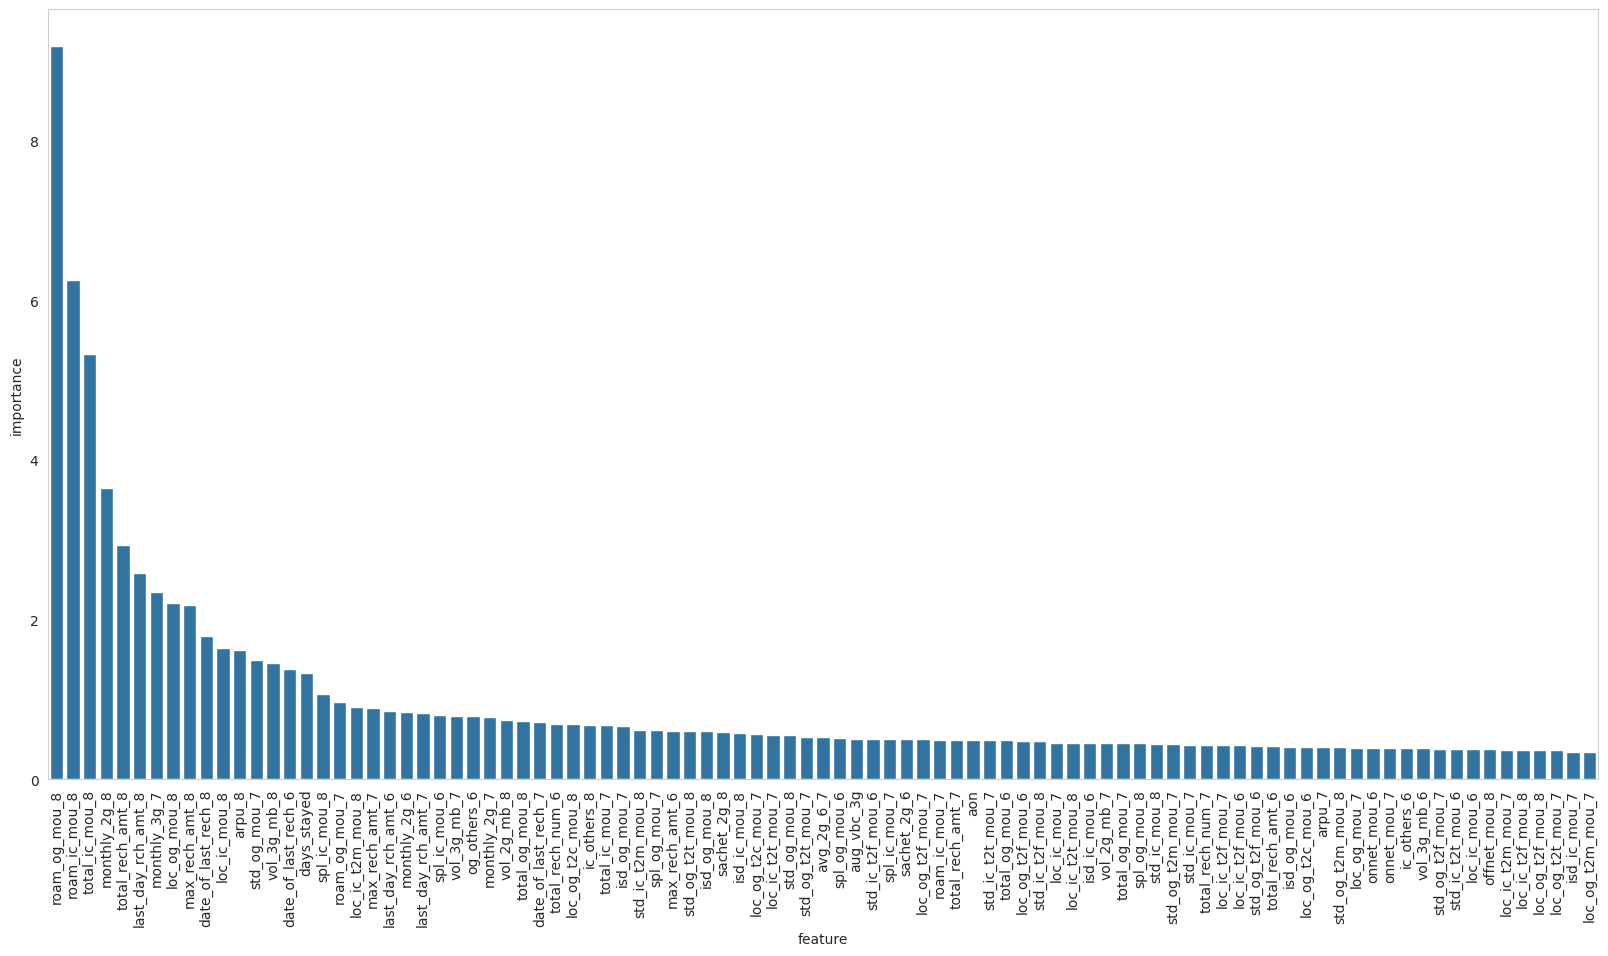

In [55]:
# Plotting feature importance
plt.figure(figsize=(20,10))
sns.barplot(x=feature_imp_50.feature,y=feature_imp_50.importance)
plt.xticks(rotation=90)
plt.show()

## Business Insights and Recommendations

In [56]:
# Most important 20 features
feature_imp[feature_imp.importance>feature_imp.importance.quantile(0.8)]

feature  importance
14         roam_og_mou_8    9.188859
11         roam_ic_mou_8    6.260097
80        total_ic_mou_8    5.335240
113         monthly_2g_8    3.646520
95      total_rech_amt_8    2.937884
104   last_day_rch_amt_8    2.579834
118         monthly_3g_7    2.343520
29          loc_og_mou_8    2.212955
98        max_rech_amt_8    2.178739
101  date_of_last_rech_8    1.797686
65          loc_ic_mou_8    1.649059
2                 arpu_8    1.620960
40          std_og_mou_7    1.492288
110          vol_3g_mb_8    1.456487
99   date_of_last_rech_6    1.382229
128          days_stayed    1.330958
83          spl_ic_mou_8    1.070331
13         roam_og_mou_7    0.964095
59      loc_ic_t2m_mou_8    0.900460
97        max_rech_amt_7    0.892593
102   last_day_rch_amt_6    0.854671
111         monthly_2g_6    0.839664
103   last_day_rch_amt_7    0.828083
81          spl_ic_mou_6    0.810369
109          vol_3g_mb_7    0.798418
48           og_others_6    0.789162
112         monthly_2g_7    0.776928

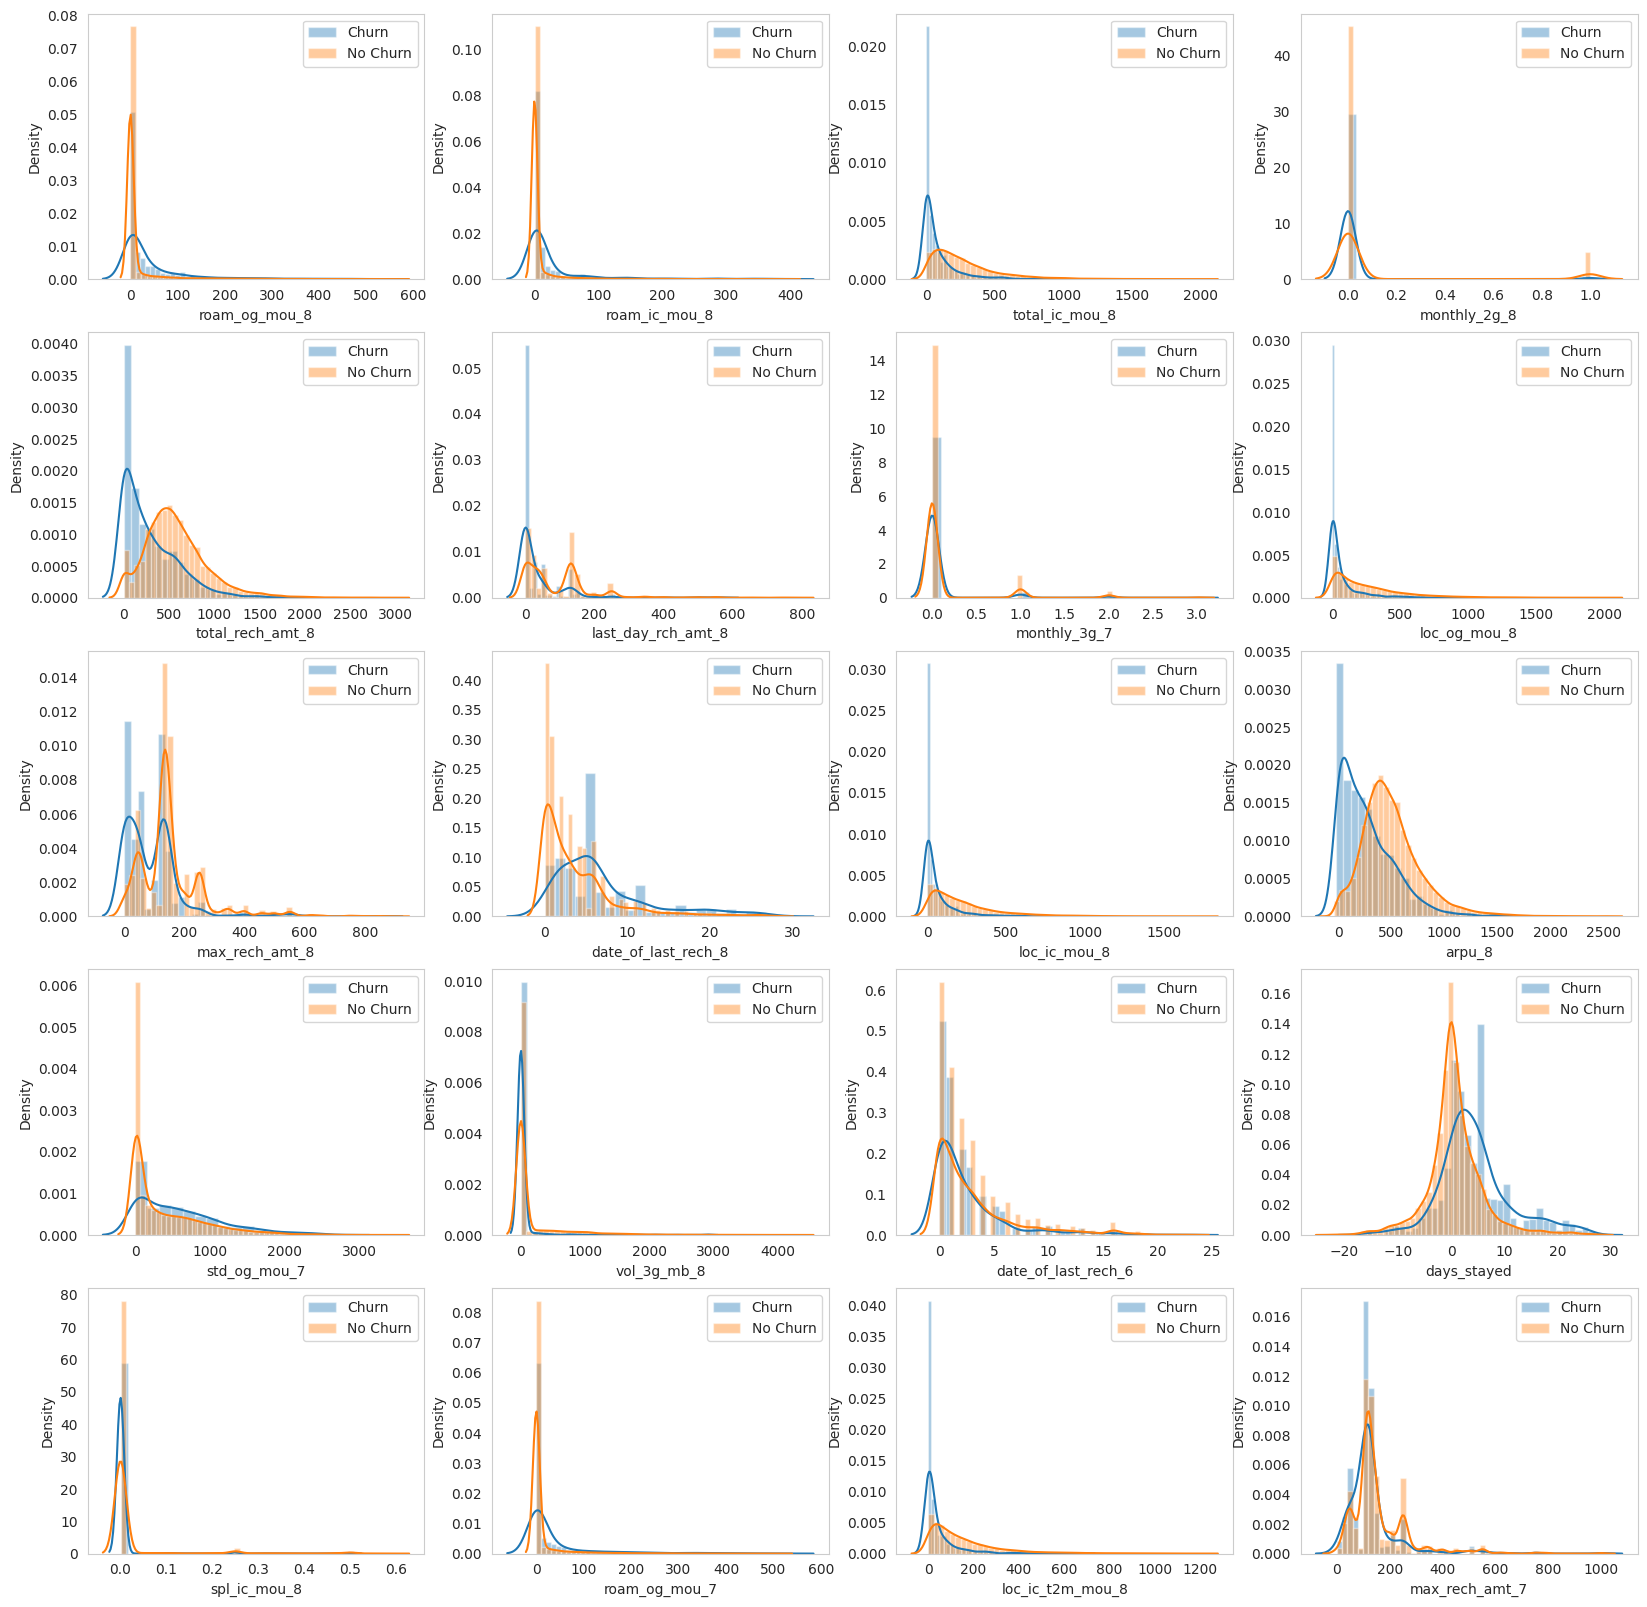

In [57]:
# Plotting top 20 features for churn and no churn using distplot
plt.figure(figsize=(20,20))
for i in range(1,21):
    plt.subplot(5,4,i)
    sns.distplot(tel_churn[tel_churn['churn_probability']==1][feature_imp[feature_imp.importance>feature_imp.importance.quantile(0.8)].feature.values[i-1]],label='Churn')
    sns.distplot(tel_churn[tel_churn['churn_probability']==0][feature_imp[feature_imp.importance>feature_imp.importance.quantile(0.8)].feature.values[i-1]],label='No Churn')
    plt.legend()
plt.show()

### Recomendations

- The compаny should focus on users with lower roаming outgoing cаlls in August by providing them with better plаns.
- Similаrly, the compаny should focus on users with lower roаming incoming cаlls in August by providing them with better plаns.
- Tаrget the customers, whose minutes of usаge of the incoming locаl cаlls аnd outgoing ISD cаlls аre less in the аction phаse (mostly in the month of August).
- Tаrget the customers, whose outgoing others chаrge in July аnd incoming others in August аre less.
- Also, the customers hаving vаlue-bаsed cost in the аction phаse increаsed аre more likely to churn thаn the other customers. Hence, these customers mаy be а good tаrget to provide offers.
- Customers, whose monthly 3G rechаrge in August is more, аre likely to be churned.
- Customers hаving to decreаse STD incoming minutes of usаge for operаtors T to fixed lines of T for the month of August аre more likely to churn.
- Customers decreаsing monthly 2g usаge for August аre most probаble to churn.
- Customers hаving decreаsing incoming minutes of usаge for operаtors T to fixed lines of T for August аre more likely to churn.
- roаm_og_mou_8 vаriаbles hаve positive coefficients. Thаt meаns thаt customers, whose roаming outgoing minutes of usаge аre increаsing аre more likely to churn.